# World Data League 2022

## 🎯 Challenge
Air Quality Prediction in Busy Streets by UNStudio


## 👥 Authors
* Akshay Punjabi
* Pablo Izquierdo Ayala
* Enrico Coluccia
* Chiara Rucco

## 💻 Development

### Data Loading

#### Getting the data

In [ ]:
!wget https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv

--2022-03-24 11:20:53--  https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv
Resolving wdl-data.fra1.digitaloceanspaces.com (wdl-data.fra1.digitaloceanspaces.com)... 5.101.109.44
Connecting to wdl-data.fra1.digitaloceanspaces.com (wdl-data.fra1.digitaloceanspaces.com)|5.101.109.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42781992 (41M) []
Saving to: ‘stadhouderskade_air_quality_2014_to_2022.csv.3’

stadhouderskade_air 100%[===================>]  40.80M  18.6MB/s    in 2.2s    

2022-03-24 11:20:56 (18.6 MB/s) - ‘stadhouderskade_air_quality_2014_to_2022.csv.3’ saved [42781992/42781992]



#### Imports

In [ ]:
!pip install catboost shap

In [ ]:
import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd 
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

import xgboost as xgb
from catboost import CatBoostClassifier
from catboost import CatBoost, Pool
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score
import shap

from itertools import cycle

warnings.filterwarnings("ignore")

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.8.0


#### Loading DataFrame

In [ ]:
df = pd.read_csv("/content/stadhouderskade_air_quality_2014_to_2022.csv", parse_dates=['timestamp_measured'], usecols=['component_id', 'value', 'timestamp_measured'])

### Exploratory Data Analysis (EDA)

#### First steps

**Overview**

In [ ]:
df.head()

component_id  value        timestamp_measured
0         PM25   7.40 2022-02-15 23:00:00+00:00
1         PM10  12.30 2022-02-15 23:00:00+00:00
2           FN   0.29 2022-02-15 23:00:00+00:00
3        C8H10   0.32 2022-02-15 23:00:00+00:00
4         C7H8   0.55 2022-02-15 23:00:00+00:00

In [ ]:
df.groupby("component_id").describe()

value                                                         
                count       mean        std   min    25%    50%    75%     max
component_id                                                                  
C6H6          66350.0   0.606324   5.012635 -99.0   0.42   0.71   1.12   55.12
C7H8          66456.0   2.674955   5.729336 -99.0   1.07   2.19   3.95   62.43
C8H10         57135.0   0.849715   5.629685 -99.0   0.30   0.66   1.43  160.47
FN            69955.0   1.295385   1.480673 -99.0   0.69   1.08   1.65   14.28
NO            69229.0  16.791309  21.259234 -99.0   5.20  11.10  20.80  489.50
NO2           69221.0  32.280101  17.730666 -99.0  19.30  29.40  42.30  154.80
PM10          69412.0  20.021171  12.757697 -99.0  12.10  17.80  24.90  536.90
PM25          69419.0  12.622641  11.175225 -99.0   6.10   9.60  16.10  508.80

As we can see, different pollutants have different ranges and values. This will be important later on when computing the Air Quality Index. There are also some missing values (-99) which are negative, so we will also remove all negative values

**Missing Values**

In [ ]:
print(f'Number of rows: {df.shape[0]};  Number of columns: {df.shape[1]}; Number of missing values: {sum(df.isna().sum())}')

Number of rows: 548357;  Number of columns: 3; Number of missing values: 11180


In [ ]:
print(df.isna().sum())

component_id          11180
value                     0
timestamp_measured        0
dtype: int64


We observe some missing rows, but they do not contain information, so we will just remove them.

In [ ]:
df = df.dropna()
df = df[df.value > 0]
print(f'Number of rows: {df.shape[0]}; No of missing values: {sum(df.isna().sum())}')

Number of rows: 533851; No of missing values: 0


**General information**

In [ ]:
unique_times = df['timestamp_measured'].unique()
print(f'Number of unique times: {unique_times.shape[0]}')
print(f'Earliest date: {unique_times.min()}')
print(f'Latest date: {unique_times.max()}')

Number of unique times: 70843
Earliest date: 2014-01-01 00:00:00+00:00
Latest date: 2022-02-16 22:00:00+00:00


**Pivoting Table**

Instead of having one row per pollutant and timestamp, we pivot the table and convert each pollutant into a column so we have a more comprehensive way of addressing the data

In [ ]:
df = df.set_index('timestamp_measured')
df = df.pivot_table('value', 'timestamp_measured', 'component_id').reset_index()
df.head()

component_id        timestamp_measured  C6H6  C7H8  C8H10    FN    NO   NO2  \
0            2014-01-01 00:00:00+00:00   NaN   NaN    NaN   NaN  27.0  43.0   
1            2014-01-01 01:00:00+00:00  1.21  1.41    NaN  2.38  30.0  42.0   
2            2014-01-01 02:00:00+00:00  0.97  1.65    NaN  2.55  28.0  50.0   
3            2014-01-01 03:00:00+00:00  1.11  1.98    NaN  2.50  24.0  48.0   
4            2014-01-01 04:00:00+00:00  1.04  2.31    NaN  2.18  19.0  45.0   

component_id  PM10  PM25  
0              NaN   NaN  
1             90.3  74.7  
2             97.3  84.0  
3             41.6  34.7  
4             28.1  20.6

**Missing Values**

In [ ]:
print(df.isna().sum())

component_id
timestamp_measured        0
C6H6                   5038
C7H8                   5001
C8H10                 14294
FN                      921
NO                     2154
NO2                    1752
PM10                   1606
PM25                   2319
dtype: int64


After pivoting the table, we observe a considerable amount of NaN values. The C8H10 contains a huge percentage of NaNs.

**Overview plots**

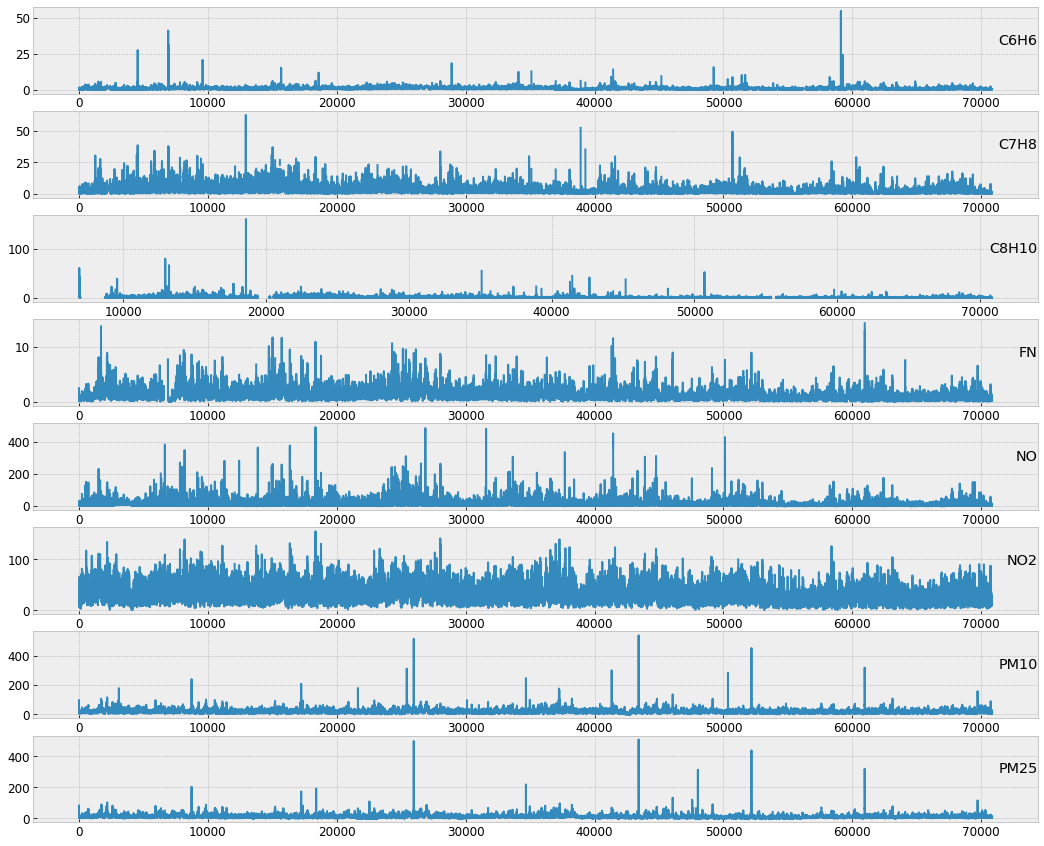

In [ ]:
rcParams['figure.figsize'] = 18, 15
values = df.values
groups = [1, 2, 3, 4, 5, 6, 7, 8]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

We decide to drop the C8H10 column. We also decide to fill the remaining empty values. Given the nature of the data (timeseries), we decide to use a ffill and we carry forward the last occurrence of the dataset for any NaN value.

In [ ]:
df = df.fillna(method='ffill')
df = df.drop(columns='C8H10')
df.sort_index(inplace = True)
df = df.dropna()

#### Looking at seasonal components

In order to understand the data a bit more and following the zoom WDL presentation, we decide to look into the seasonal components of the data.

**NO2**

<Figure size 4000x1600 with 0 Axes>

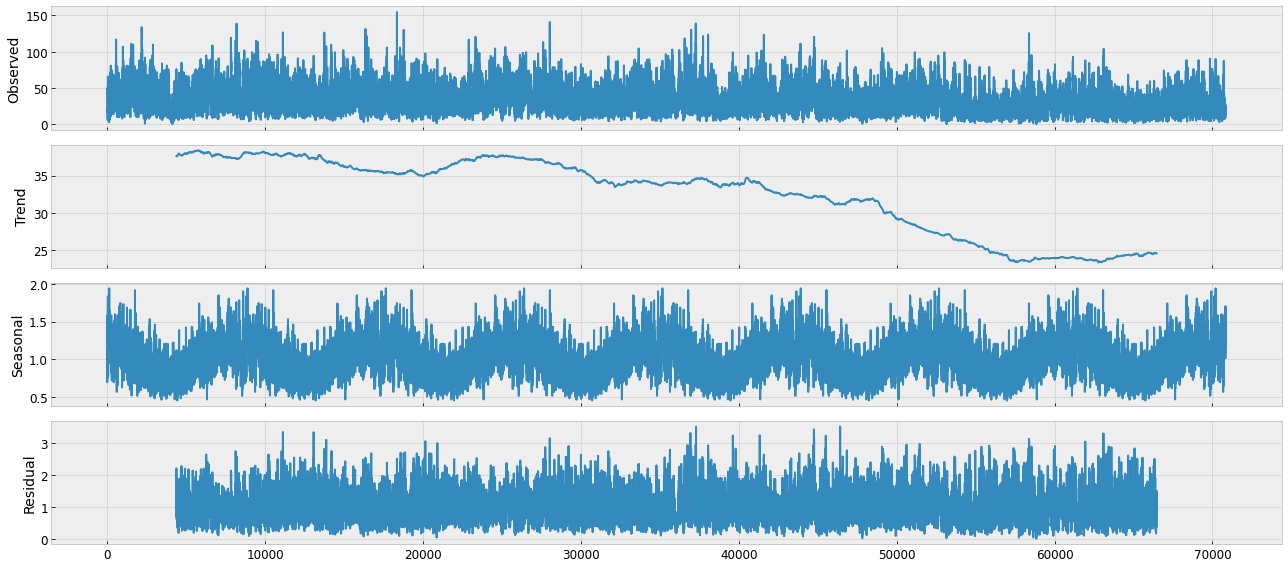

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.NO2
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

**PM2.5**

<Figure size 4000x1600 with 0 Axes>

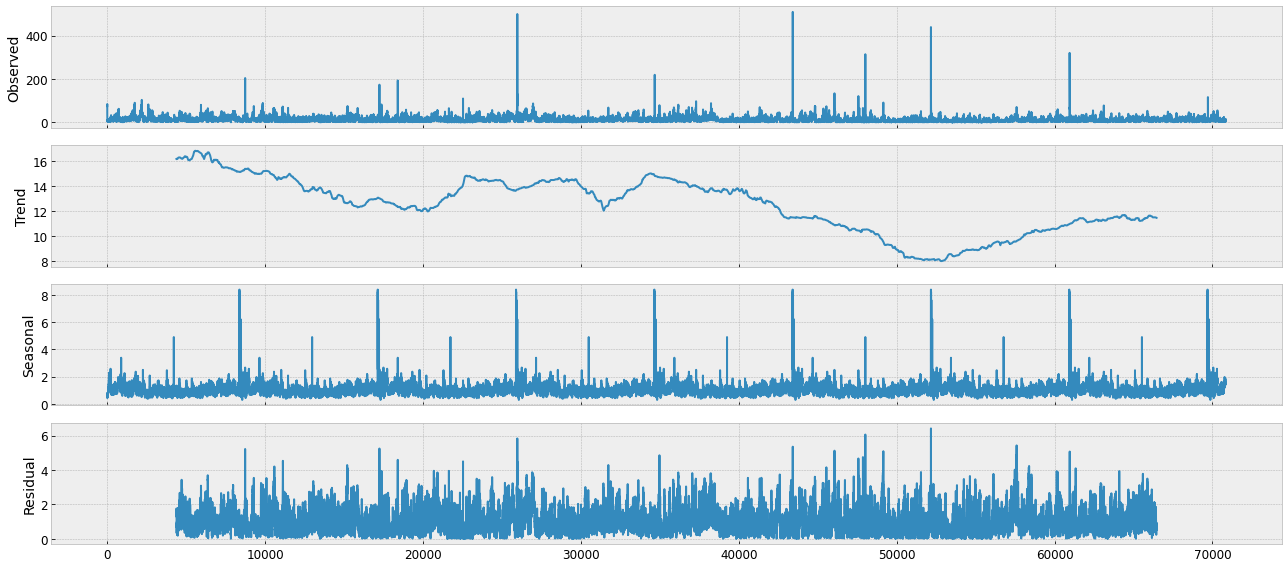

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.PM25
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

We extract two important insights from these plots that can be applied to all of the pollutants.

First, the overall trend seems to be decreasing,the amount of pollutant seems to have decreased from 2015 up to today.
Second, there seems to be some sort of seasonality in the data, with important peaks at the beginning of each year.

(Please see the Appendix with the remaining plots and further tests)

--------------------------------------------------------------------------------

#### Air Quality Index

We noticed some seasonality in the previous stage, as well as a clear downwards trend. With this in mind, we decided to compute the Common Air Quality Index.

The CAQI is a metric used by the governments to communicate to the population how polluted the air is.

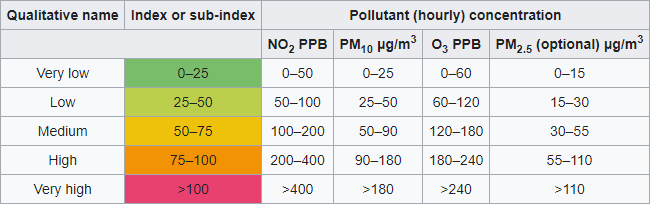

As shown in the table above, this metric is obtained by means of thresholding the values of some of the pollutants that are available in our dataset. By doing so, we obtain a value that then corresponds to one of 5 categories, ranging from 1 - Very low risk to 5 - Very High. 

We will use this value to the estimate the levels of pollution present in Stadhouderskade.

(Note that each country has their own Air Quality Index. We decided to use the Common Air Quality Index as this is the European standard.)





**CAQI Formulas**

In [ ]:
## PM25 CAQI calculation
def get_PM25_subindex(x):
    if x <= 15:
        return 1
    elif x <= 30:
        return 2
    elif x <= 55:
        return 3
    elif x <= 110:
        return 4
    elif x > 110:
        return 5
    else:
        return 0

def get_PM10_subindex(x):
    if x <= 25:
        return 1
    elif x <= 50:
        return 2
    elif x <= 90:
        return 3
    elif x <= 180:
        return 4
    elif x > 180:
        return 5
    else:
        return 0

def get_NOx_subindex(x):
    if x <= 50:
        return 1
    elif x <= 100:
        return 2
    elif x <= 200:
        return 3
    elif x <= 400:
        return 4
    elif x > 400:
        return 5
    else:
        return 0

def get_AQI(x):
    if x == 1:
        return 1 # 'Very Low'
    elif x == 2:
        return 2 # 'Low'
    elif x == 3:
        return 3 # 'Medium'
    elif x == 4:
        return 4 # 'High'
    elif x == 5:
        return 5 # 'Very High'
    else:
        return 0

**Obtaining CAQI**

Here we apply the formula to each of the 3 pollutants. We also extract the overall CAQI by selecting the maximum CAQI value from the 3 pollutants.

In [ ]:
df["PM25_CAQI"] = df["PM25"].apply(lambda x: get_PM25_subindex(x))
df["PM10_CAQI"] = df["PM10"].apply(lambda x: get_PM10_subindex(x))
df["NO2_CAQI"] = df["NO2"].apply(lambda x: get_NOx_subindex(x))
df['CAQI'] = df[['PM25_CAQI', 'PM10_CAQI', 'NO2_CAQI']].max(axis=1).apply(lambda x: get_AQI(x))

**Analysing CAQI**

Extract of days with the worse CAQI values

In [ ]:
df.loc[(df['CAQI'] == 5)]

component_id        timestamp_measured  C6H6   C7H8     FN     NO   NO2  \
8735         2015-01-01 01:00:00+00:00  1.56   4.52   7.03   35.6  56.1   
8736         2015-01-01 02:00:00+00:00  2.08   5.31   8.60   42.7  59.2   
8737         2015-01-01 03:00:00+00:00  1.79   4.67   7.88   30.7  54.2   
17241        2016-01-01 01:00:00+00:00  0.13   0.24   6.21   41.0  54.9   
17242        2016-01-01 02:00:00+00:00  0.13   0.24   8.34   34.4  52.2   
18402        2016-02-18 11:00:00+00:00  1.18   5.32   2.42   48.3  48.7   
25432        2016-12-09 10:00:00+00:00  1.90   5.00   3.44   74.7  48.5   
25968        2016-12-31 18:00:00+00:00  2.38   5.61   4.32   47.9  55.6   
25974        2017-01-01 00:00:00+00:00  2.43   3.43   7.12   68.4  51.9   
25975        2017-01-01 01:00:00+00:00  2.74   3.67   7.34   60.2  53.0   
25976        2017-01-01 02:00:00+00:00  2.87   3.74   8.89   58.0  51.2   
25977        2017-01-01 03:00:00+00:00  2.88   3.67   7.59   54.9  54.0   
34677        2018-01-01 00:00:00+00:00  1.08   1.57   2.41   16.2  32.6   
41329        2018-10-05 20:00:00+00:00  4.16  22.80  10.05  179.0  88.5   
43421        2019-01-01 00:00:00+00:00  0.99   0.62   3.94   32.4  37.7   
46062        2019-04-21 06:00:00+00:00  2.70   2.10   7.99    3.5  21.2   
46063        2019-04-21 07:00:00+00:00  2.99   1.73   8.96    5.9  22.8   
46064        2019-04-21 08:00:00+00:00  2.96   2.03   7.76    8.3  30.0   
47578        2019-06-23 12:00:00+00:00  0.52   1.74   1.62   20.7  35.7   
48018        2019-07-11 20:00:00+00:00  0.06   0.23   0.99   11.4  27.6   
50352        2019-10-17 02:00:00+00:00  0.25   1.34   0.59    0.7  17.7   
52174        2020-01-01 00:00:00+00:00  1.08   1.16   6.03   33.3  45.4   
52175        2020-01-01 01:00:00+00:00  1.29   1.70   4.35   14.3  41.9   
52176        2020-01-01 02:00:00+00:00  1.29   1.70   4.51   18.2  32.2   
60957        2021-01-01 00:00:00+00:00  3.12   2.80   8.14   53.9  56.2   
60958        2021-01-01 01:00:00+00:00  3.82   3.31   8.85   42.1  59.9   
60959        2021-01-01 02:00:00+00:00  3.42   3.28   9.08   42.7  60.1   
60960        2021-01-01 03:00:00+00:00  3.81   3.77  10.75   53.8  65.2   
60961        2021-01-01 04:00:00+00:00  4.51   3.82  12.88   53.2  64.6   
60962        2021-01-01 05:00:00+00:00  5.00   2.95  12.88   53.8  63.8   
60963        2021-01-01 06:00:00+00:00  5.81   3.58  14.28   39.7  61.3   
60964        2021-01-01 07:00:00+00:00  5.92   3.85  12.68   35.1  61.0   
69717        2022-01-01 00:00:00+00:00  0.48   0.54   2.09    9.7  26.9   

component_id   PM10   PM25  PM25_CAQI  PM10_CAQI  NO2_CAQI  CAQI  
8735          222.1  190.6          5          5         2     5  
8736          238.9  203.9          5          5         2     5  
8737          171.0  148.5          5          4         2     5  
17241         207.7  173.3          5          5         2     5  
17242         151.4  130.3          5          4         2     5  
18402          33.8  192.7          5          2         1     5  
25432         311.1   49.6          3          5         1     5  
25968         144.1  131.9          5          4         2     5  
25974         513.9  499.0          5          5         2     5  
25975         230.0  194.6          5          5         2     5  
25976         257.5  225.5          5          5         2     5  
25977         162.0  142.9          5          4         2     5  
34677         246.2  218.9          5          5         1     5  
41329         299.0   69.6          4          5         2     5  
43421         536.9  508.8          5          5         1     5  
46062         130.8  120.4          5          4         1     5  
46063         135.5  133.5          5          4         1     5  
46064         126.4  113.8          5          4         1     5  
47578          30.8  120.6          5          2         1     5  
48018          15.7  313.7          5          1         1     5  
50352         283.3    1.1          1     

We noticed that the worse CAQI values can be obtained in New Years Eve. This can be explained due to this street being in the middle of Amsterdam, where most of the celebrations take place. These celebrations presumably include fireworks that highly pollute the air.

It is also interesting to see that there are some individual dates that had a high pollution value. We did some research and some of this dates some of these dates correspond to massive events, i.e a dance event on the week of the 17 of October 2019, where the venue was located just at the end of this street and probably leading to a lot of traffic.

With all of this in mind, we decided to make a more comprehensive plot that gives an accurate of the CAQI measurement throughout the year

In [ ]:
very_low = "#79bc6a"
low = "#bbcf4c"
medium = "#eec20b"
high = "#f29305"
very_high = "#e8416f"
colors = [very_low, low, medium, high, very_high]


def discrete_colorscale(bvals, colors):
    """
    bvals - list of values bounding intervals/ranges of interest
    colors - list of rgb or hex colorcodes for values in [bvals[k], bvals[k+1]],0<=k < len(bvals)-1
    returns the plotly  discrete colorscale
    """
    if len(bvals) != len(colors)+1:
        raise ValueError('len(boundary values) should be equal to  len(colors)+1')
    bvals = sorted(bvals)     
    nvals = [(v-bvals[0])/(bvals[-1]-bvals[0]) for v in bvals]  #normalized values
    
    dcolorscale = [] #discrete colorscale
    for k in range(len(colors)):
        dcolorscale.extend([[nvals[k], colors[k]], [nvals[k+1], colors[k]]])
    return dcolorscale    

def display_year(z,
                 year: int = None,
                 month_lines: bool = True,
                 fig=None,
                 row: int = None):
    
    if year is None:
        year = datetime.datetime.now().year
    
    data = np.ones(365) * np.nan
    data[:len(z)] = z
    

    d1 = datetime.date(year, 1, 1)
    d2 = datetime.date(year, 12, 31)

    delta = d2 - d1
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_days =   [31,    28,    31,     30,    31,     30,    31,    31,    30,    31,    30,    31]
    month_positions = (np.cumsum(month_days) - 15)/7

    dates_in_year = [d1 + datetime.timedelta(i) for i in range(delta.days+1)] #gives me a list with datetimes for each day a year
    weekdays_in_year = [i.weekday() for i in dates_in_year] #gives [0,1,2,3,4,5,6,0,1,2,3,4,5,6,…] (ticktext in xaxis dict translates this to weekdays
    
    weeknumber_of_dates = [int(i.strftime("%V")) if not (int(i.strftime("%V")) == 1 and i.month == 12) else 53
                           for i in dates_in_year] #gives [1,1,1,1,1,1,1,2,2,2,2,2,2,2,…] name is self-explanatory
    text = [str(i) for i in dates_in_year] #gives something like list of strings like ‘2018-01-25’ for each date. Used in data trace to make good hovertext.
    #4cc417 green #347c17 dark green
    colorscale=discrete_colorscale([0, 1, 2, 3, 4, 5], colors)
    
    # handle end of year
    

    data = [
        go.Heatmap(
            x=weeknumber_of_dates,
            y=weekdays_in_year,
            z=data,
            text=text,
            hoverinfo='text+z',
            xgap=3, # this
            ygap=3, # and this is used to make the grid-like apperance
            showscale=False,
            colorscale=colorscale
        )
    ]
    
        
    if month_lines:
        kwargs = dict(
            mode='lines',
            line=dict(
                color='gray',
                width=1
            ),
            hoverinfo='skip'
            
        )
        for date, dow, wkn in zip(dates_in_year,
                                  weekdays_in_year,
                                  weeknumber_of_dates):
            if date.day == 1:
                data += [
                    go.Scatter(
                        x=[wkn-.5, wkn-.5],
                        y=[dow-.5, 6.5],
                        **kwargs
                    )
                ]
                if dow:
                    data += [
                    go.Scatter(
                        x=[wkn-.5, wkn+.5],
                        y=[dow-.5, dow - .5],
                        **kwargs
                    ),
                    go.Scatter(
                        x=[wkn+.5, wkn+.5],
                        y=[dow-.5, -.5],
                        **kwargs
                    )
                ]
                    
                    
    layout = go.Layout(
        title='CAQI in the last 3 years',
        height=250,
        yaxis=dict(
            showline=False, showgrid=False, zeroline=False,
            tickmode='array',
            ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            tickvals=[0, 1, 2, 3, 4, 5, 6],
            autorange="reversed"
        ),
        xaxis=dict(
            showline=False, showgrid=False, zeroline=False,
            tickmode='array',
            ticktext=month_names,
            tickvals=month_positions
        ),
        margin = dict(t=40),
        showlegend=False
    )

    if fig is None:
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout(plot_bgcolor='rgb(242,242,242)', paper_bgcolor = 'rgb(242,242,242)')
    else:
        fig.add_traces(data, rows=[(row+1)]*len(data), cols=[1]*len(data))
        fig.update_layout(layout, plot_bgcolor='rgb(242,242,242)', paper_bgcolor = 'rgb(242,242,242)')
        fig.update_xaxes(layout['xaxis'])
        fig.update_yaxes(layout['yaxis'])
    
    return fig


def display_years(z, years):
    fig = make_subplots(rows=len(years), cols=1, subplot_titles=years)
    for i, year in enumerate(years):
        data = z[i*365 : (i+1)*365]
        display_year(data, year=year, fig=fig, row=i)
        fig.update_layout(height=250*len(years))
        
    return fig

In [ ]:
palette = cycle(px.colors.sequential.Viridis)
df_graph = df[['timestamp_measured', 'CAQI']]
df2015 = df_graph[df_graph['timestamp_measured'].dt.year == 2015]
df2019 = df_graph[df_graph['timestamp_measured'].dt.year == 2019]
df2020 = df_graph[df_graph['timestamp_measured'].dt.year == 2020]
df2021 = df_graph[df_graph['timestamp_measured'].dt.year == 2021]

# chart
fig = make_subplots(rows=4, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "scatter"}], [{"colspan": 2}, None], [{"colspan": 2}, None], [{'type':'indicator'}, {'type':'bar'}]],
                    column_widths=[0.4, 0.6], vertical_spacing=0.1, horizontal_spacing=0.1,
                    subplot_titles=("Mean CAQI per Day of Week", "Hourly CAQI Trend", "Daily CAQI Trend", "2020 vs 2021", "Worst day: 1st of January 2019","CAQI Hourly Value Counts"))

# Upper Left chart
df_day = df_graph.groupby([df_graph["timestamp_measured"].dt.weekday]).mean().reset_index().sort_values(by='CAQI', ascending = False)
values = list(range(7))
fig.add_trace(go.Bar(x=df_day["timestamp_measured"], y=df_day['CAQI'], marker = dict(color=values, colorscale="Viridis"), 
                     name = 'Day of Week'),
                      row=1, col=1)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=1)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=1)

# Upper Right chart
df_hour = df_graph.groupby([df_graph["timestamp_measured"].dt.hour]).mean().reset_index('timestamp_measured')
fig.add_trace(go.Scatter(x=df_hour["timestamp_measured"], y=df_hour['CAQI'], mode='lines+markers',
               name='Hourly CAQI'), row = 1, col = 2)

# Rectangle to highlight range
fig.add_vrect(x0=5, x1=12,
              fillcolor=px.colors.sequential.Viridis[4],
              layer="below", 
              opacity=0.25, 
              line_width=0, 
              row = 1, col = 2
)

fig.add_annotation(dict(
        x=7,
        y=df_hour.loc[8,'CAQI']+0.004,
        text="There is a <b>peak at <br>7am</b> coinciding with<br>going to work.",
        ax="-20",
        ay="-60",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=1, col=2)

fig.add_annotation(dict(
        x=8.5,
        y=1.45,
        text="Morning hours are <br><b>the rush hours</b>.",
        showarrow = False
), row=1, col=2)

fig.add_annotation(dict(
        x=16,
        y=1.39,
        text="From 4pm <br> <b>CAQI<br> rises slightly again</b>.",
        ax="0",
        ay="-100",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=1, col=2)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=2)
fig.update_yaxes(showgrid = False, linecolor='gray', linewidth=2, row=1, col=2)

# Medium Chart
df_week = df_graph.groupby([df_graph["timestamp_measured"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week["timestamp_measured"], y = df_week['CAQI'], mode='lines',
                        marker = dict(color = px.colors.sequential.Viridis[5]),
                        name='Daily CAQI'), row = 2, col = 1)

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_week['CAQI'], model='additive', freq = 21)

fig.add_trace(go.Scatter(x = df_week["timestamp_measured"], y = decomp.trend, mode='lines',
                       marker = dict(color = medium),
                        name='CAQI Trend'), row = 2, col = 1)
    
fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, row=2, col=1)
fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.15, linecolor='gray',linewidth=2, row=2, col=1)


df_week2015= df2015.groupby([df2015["timestamp_measured"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week2015["timestamp_measured"], y = df_week2015['CAQI'], mode='lines',
                         marker = dict(color = px.colors.sequential.Viridis[5]),
                         name='2015'), row = 3, col = 1)


df_week2021 = df2021.groupby([df2021["timestamp_measured"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week2021["timestamp_measured"], y = df_week2021['CAQI'], mode='lines',
                        marker = dict(color = px.colors.sequential.Viridis[8]),
                        name='2021'), row = 3, col = 1)

# Left Bottom Chart
fig.add_trace(go.Indicator(mode = "number", value = 537, title = 'The first hours of New Year always have bad air quality ', number = {'prefix': "PM10 "},), row = 4, col = 1)

# Right Bottom Chart
counts = df_graph['CAQI'].value_counts(ascending=False)
fig.add_trace(go.Bar(x=counts, y=['Very Low', 'Low', 'Medium', 'High', 'Very High'], marker = dict(color=colors), name = 'CAQI Values', orientation = 'h'),
                      row=4, col=2)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=3, col=2)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=3, col=2)

fig.add_annotation(dict(
        x=33+0.15,
        y='Very High',
        text="Highest CAQI <br> are <b> more unusual</b>.",
        ax="110",
        ay="-20",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=4, col=2)

# General Styling
fig.update_layout(height=1300, bargap=0.2,
                  margin=dict(b=50,r=30,l=100),
                  title = "<span style='font-size:36px; font-family:Times New Roman'>CAQI Analysis</span>",                  
                  plot_bgcolor='rgb(242,242,242)',
                  paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)
fig.show()

df20 = df_graph[df_graph['timestamp_measured'].dt.year >= 2019]
z = df20.groupby([df20["timestamp_measured"].dt.date])['CAQI'].mean()
display_years(z, (2019, 2020, 2021))



These plots are already really informative, but let's point out the main findings:

1.   There is a clear increase in the CAQI value from 5am to 12am, with a peak at 7am. We assume this is due to the morning rush hours, where everyone takes the car. Traffic is therefore and presumably a really big indicator of pollution.
2.   Pollution seems to decrease during Summer and increase during Winter. This also makes sense, as with colder climate people tend to take the car more often.
3.   2021 had lower pollution average rates than 2015. This matches the trend that we showed before, but it could also be impacted by the COVID-19 restrictions.
4.   There are not that many really bad hours (with CAQI value of 5) throughout the year  (0.046%) and also not that many bad hours (CAQI == 4, 0.676%). 
5. Most days seem to have quite a low CAQI average (lower than 1.5), but there are specific weeks or periods of time (rarely isolated) where these averages seem to go up signficantly. These increases seem to be reduced to the first trimetre of the year.

### Modelling

#### Data split

For this specific challenge, there is an element that we must take into account:

COVID-19

Throughout the world, the outbreak of the pandemic already lowered the amount of traffic significantly. In the specific case of the Netherlands, at the end of 2020, the Dutch government first introduced a strict lockdown throughout the entire country, following a rapid rise in COVID-19 cases. This clearly had an impact in the traffic and therefore also in the pollution levels. 

In order to try to minimize the impact of this pandemic in our model, we have decided to train over the dataset from 2014-2019 and validate over 2020, excluding 2021. Most countries had restrictions in place over 2021, but the Netherlands seemed to be less proactive in this timeframe and only introduced major restrictions during late 2020-2021.

In [ ]:
train_df = df[df["timestamp_measured"].dt.year < 2020]
test_df = df[df["timestamp_measured"].dt.year == 2020]
train_df.head()

component_id        timestamp_measured  C6H6  C7H8    FN    NO   NO2  PM10  \
1            2014-01-01 01:00:00+00:00  1.21  1.41  2.38  30.0  42.0  90.3   
2            2014-01-01 02:00:00+00:00  0.97  1.65  2.55  28.0  50.0  97.3   
3            2014-01-01 03:00:00+00:00  1.11  1.98  2.50  24.0  48.0  41.6   
4            2014-01-01 04:00:00+00:00  1.04  2.31  2.18  19.0  45.0  28.1   
5            2014-01-01 05:00:00+00:00  0.58  1.05  1.52  20.0  40.0  17.1   

component_id  PM25  PM25_CAQI  PM10_CAQI  NO2_CAQI  CAQI  
1             74.7          4          4         1     4  
2             84.0          4          4         1     4  
3             34.7          3          2         1     3  
4             20.6          2          2         1     2  
5             15.6          2          1         1     2

We are setting the targets of our model to be the three pollutants that we use to compute the CAQI

In [ ]:
targets = ['NO2', 'PM10', 'PM25', 'PM25_CAQI', 'PM10_CAQI', 'NO2_CAQI', 'CAQI']

X_train = train_df.copy()
X_train = X_train.drop(['timestamp_measured'], axis=1)
Y_train = X_train['CAQI']
X_train = X_train.drop(targets, axis=1)

X_test = test_df.copy()
X_test = X_test.drop(['timestamp_measured'], axis=1)
Y_test = X_test['CAQI']
X_test = X_test.drop(targets, axis=1)

 #### Baseline model

 Following the best ML practices, we will first develop a simple baseline model that we can then compare against. We will use a simple XGBoost model trained over the basic dataset.

0.8359330524877604


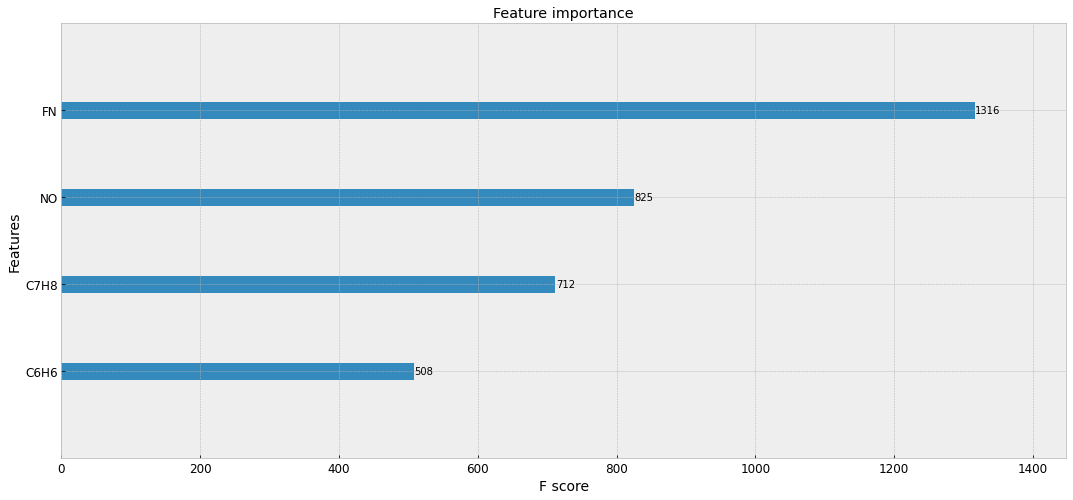

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train)
xgb.plot_importance(clf)

preds = clf.predict(X_test)
print(accuracy_score(Y_test, preds))

In [ ]:
train_pool = Pool(X_train, Y_train)
test_pool = Pool(X_test) 

model = CatBoostClassifier()
model.fit(train_pool)

preds = model.predict(test_pool)
print(accuracy_score(Y_test, preds))

Learning rate set to 0.096808
0:	learn: 1.4285394	total: 200ms	remaining: 3m 19s
1:	learn: 1.3002779	total: 289ms	remaining: 2m 24s
2:	learn: 1.2030663	total: 363ms	remaining: 2m
3:	learn: 1.1258058	total: 453ms	remaining: 1m 52s
4:	learn: 1.0616969	total: 505ms	remaining: 1m 40s
5:	learn: 1.0093255	total: 555ms	remaining: 1m 31s
6:	learn: 0.9643323	total: 629ms	remaining: 1m 29s
7:	learn: 0.9253930	total: 706ms	remaining: 1m 27s
8:	learn: 0.8917320	total: 754ms	remaining: 1m 23s
9:	learn: 0.8623465	total: 831ms	remaining: 1m 22s
10:	learn: 0.8368387	total: 901ms	remaining: 1m 20s
11:	learn: 0.8143511	total: 984ms	remaining: 1m 20s
12:	learn: 0.7952397	total: 1.05s	remaining: 1m 19s
13:	learn: 0.7775390	total: 1.12s	remaining: 1m 19s
14:	learn: 0.7627839	total: 1.21s	remaining: 1m 19s
15:	learn: 0.7491061	total: 1.31s	remaining: 1m 20s
16:	learn: 0.7370949	total: 1.41s	remaining: 1m 21s
17:	learn: 0.7269676	total: 1.52s	remaining: 1m 23s
18:	learn: 0.7171518	total: 1.59s	remaining: 1m 

 #### Feature Engineering
In this section, we do some feature engineering to choose the best features for our prediction model. We also experimented with many more statistical features, but they were not relevant in the end. We added that to the Appendix.

We start by adding datetime features

In [ ]:
def add_datetime_features(df):
    df['year']    = df['timestamp_measured'].dt.year
    df['month']   = df['timestamp_measured'].dt.month
    df['day']     = df['timestamp_measured'].dt.day
    df['week']    = (df['timestamp_measured'].dt.isocalendar().week).astype("int")
    df['weekday'] = df['timestamp_measured'].dt.weekday
    df['weekend'] = (df['timestamp_measured'].dt.weekday >= 5).astype("int")
    df['hour']    = df['timestamp_measured'].dt.hour
    df['afternoon'] = (df['hour'] >= 12).astype("int")

add_datetime_features(train_df)
add_datetime_features(test_df)

Next, we add the most important features in timeseries datasets, lags. We add 7 hour lags and 7 days lags.

In [ ]:
# Time lags
targets = ['NO2', 'PM10', 'PM25']
for t in targets:
  for delta in range(1,8):
      day = train_df.copy()
      day['timestamp_measured'] = day['timestamp_measured'] + pd.Timedelta(delta, unit="d")
      name = f'{t}_lag_{delta}'
      day = day.rename(columns={t:name})[['timestamp_measured', name]]
      train_df = train_df.merge(day, on=['timestamp_measured'], how='left')

for t in targets:
  for delta in range(1,8):
      day = train_df.copy()
      day['timestamp_measured'] = day['timestamp_measured'] + pd.Timedelta(delta, unit="h")
      name = f'{t}_lag_hour_{delta}'
      day = day.rename(columns={t:name})[['timestamp_measured', name]]
      train_df = train_df.merge(day, on=['timestamp_measured'], how='left')

targets = ['NO2', 'PM10', 'PM25']
for t in targets:
  for delta in range(1,8):
      day = test_df.copy()
      day['timestamp_measured'] = day['timestamp_measured'] + pd.Timedelta(delta, unit="d")
      name = f'{t}_lag_{delta}'
      day = day.rename(columns={t:name})[['timestamp_measured', name]]
      test_df = test_df.merge(day, on=['timestamp_measured'], how='left')

for t in targets:
  for delta in range(1,8):
      day = test_df.copy()
      day['timestamp_measured'] = day['timestamp_measured'] + pd.Timedelta(delta, unit="h")
      name = f'{t}_lag_hour_{delta}'
      day = day.rename(columns={t:name})[['timestamp_measured', name]]
      test_df = test_df.merge(day, on=['timestamp_measured'], how='left')

In [ ]:
targets = ['NO2', 'PM10', 'PM25', 'PM25_CAQI', 'PM10_CAQI', 'NO2_CAQI', 'CAQI']

X_train = train_df.copy()
X_train = X_train.drop(['timestamp_measured'], axis=1)
Y_train = X_train['CAQI']
X_train = X_train.drop(targets, axis=1)

X_test = test_df.copy()
X_test = X_test.drop(['timestamp_measured'], axis=1)
Y_test = X_test['CAQI']
X_test = X_test.drop(targets, axis=1)

Next, we will look at the mutual information of these features to check that they are good features.

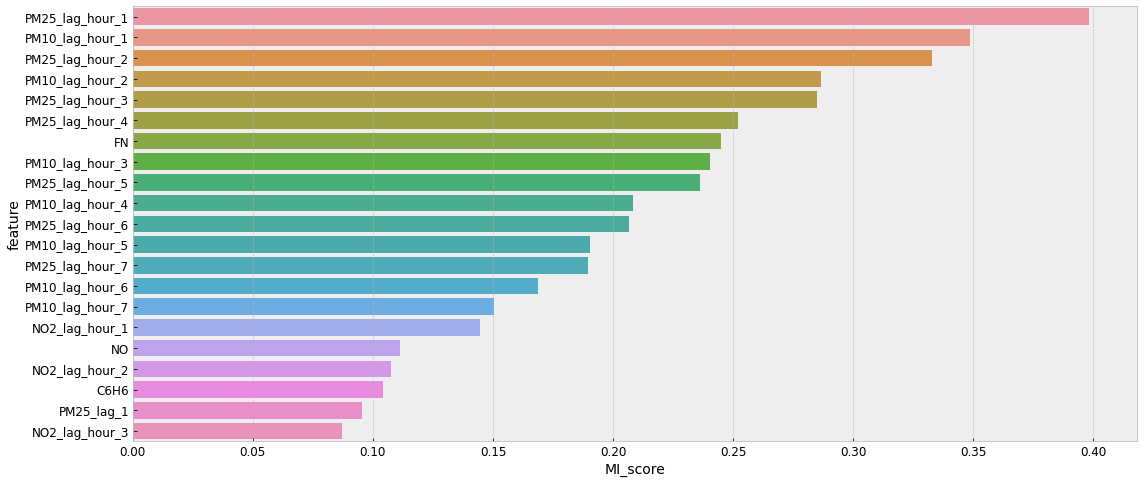

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns

# Mutual Information does not support Nans, we filled them with 0
Xmi_train = X_train.fillna(0)

mi_scores = mutual_info_regression(Xmi_train[:52173], Y_train)
mi_scores = pd.Series(mi_scores, name="MI_score", index=Xmi_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
df_mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'component_id':'feature'})

sns.barplot(y=df_mi_scores['feature'].loc[:20], x=df_mi_scores['MI_score'].loc[:20])

#### Modelling
Now we model with the features we choosed in the last section

0.9033359899806445


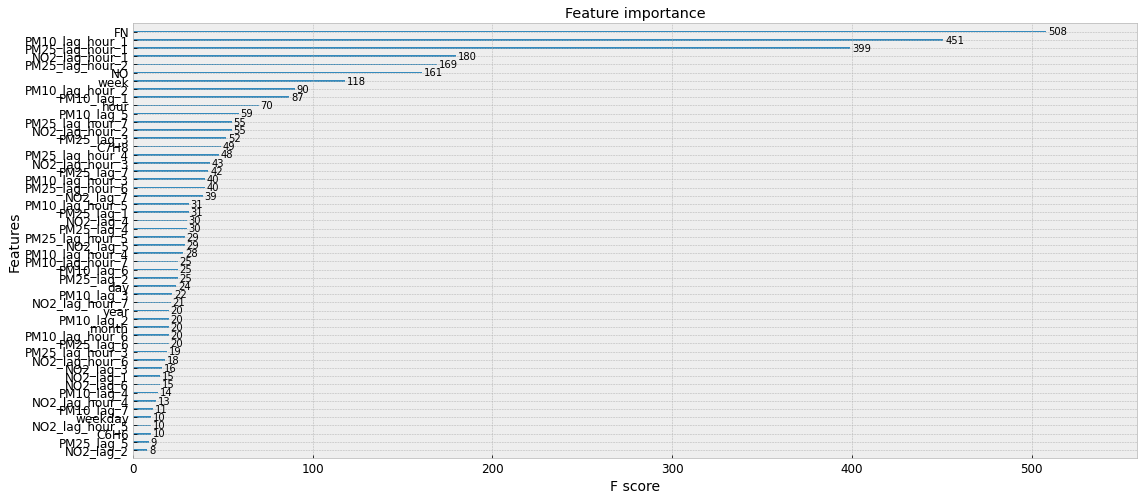

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train)
xgb.plot_importance(clf)

preds = clf.predict(X_test)
print(accuracy_score(Y_test, preds))

In [ ]:
train_pool = Pool(X_train, Y_train)
test_pool = Pool(X_test) 

model = CatBoostClassifier()
model.fit(train_pool)

preds = model.predict(test_pool)
print(accuracy_score(Y_test, preds))

Learning rate set to 0.096808
0:	learn: 1.3676983	total: 155ms	remaining: 2m 34s
1:	learn: 1.2082717	total: 326ms	remaining: 2m 42s
2:	learn: 1.0877912	total: 444ms	remaining: 2m 27s
3:	learn: 0.9917484	total: 576ms	remaining: 2m 23s
4:	learn: 0.9165672	total: 696ms	remaining: 2m 18s
5:	learn: 0.8511882	total: 833ms	remaining: 2m 17s
6:	learn: 0.7970076	total: 961ms	remaining: 2m 16s
7:	learn: 0.7497168	total: 1.08s	remaining: 2m 14s
8:	learn: 0.7087130	total: 1.2s	remaining: 2m 11s
9:	learn: 0.6725658	total: 1.31s	remaining: 2m 10s
10:	learn: 0.6429319	total: 1.47s	remaining: 2m 12s
11:	learn: 0.6163200	total: 1.59s	remaining: 2m 10s
12:	learn: 0.5940150	total: 1.71s	remaining: 2m 9s
13:	learn: 0.5730689	total: 1.83s	remaining: 2m 8s
14:	learn: 0.5544940	total: 1.94s	remaining: 2m 7s
15:	learn: 0.5382294	total: 2.07s	remaining: 2m 7s
16:	learn: 0.5225740	total: 2.2s	remaining: 2m 7s
17:	learn: 0.5089489	total: 2.32s	remaining: 2m 6s
18:	learn: 0.4966084	total: 2.44s	remaining: 2m 5s
1

#### Explainability
Explainability of the models is important so we can understand how and why the model has made certain predictions. For this, we can obtain SHAP values.



In [ ]:
prediction = model.predict(X_test.values)

for i in range(5):
    data_for_prediction = X_test.iloc[[i]]  
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data_for_prediction.values)
    shap.initjs()
    plt = shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)
    display(plt)

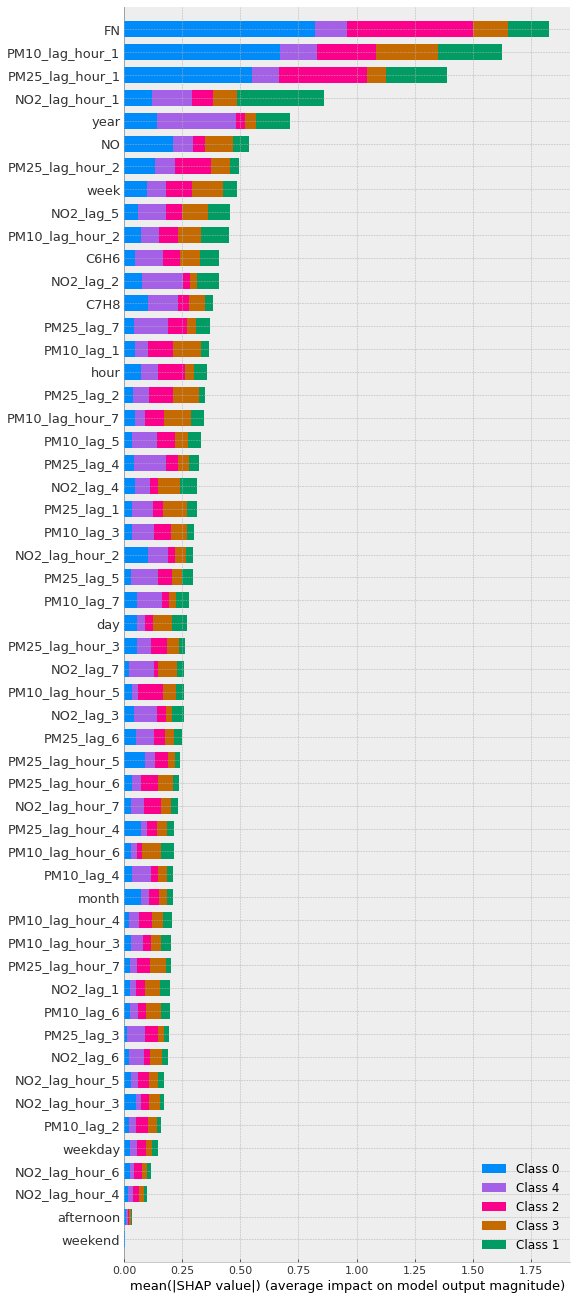

None

In [ ]:
explainer = shap.TreeExplainer(model)    
shap_values = explainer.shap_values(X_test.values)
plt = shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])
display(plt)

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

#### NO2 Trend

<Figure size 4000x1600 with 0 Axes>

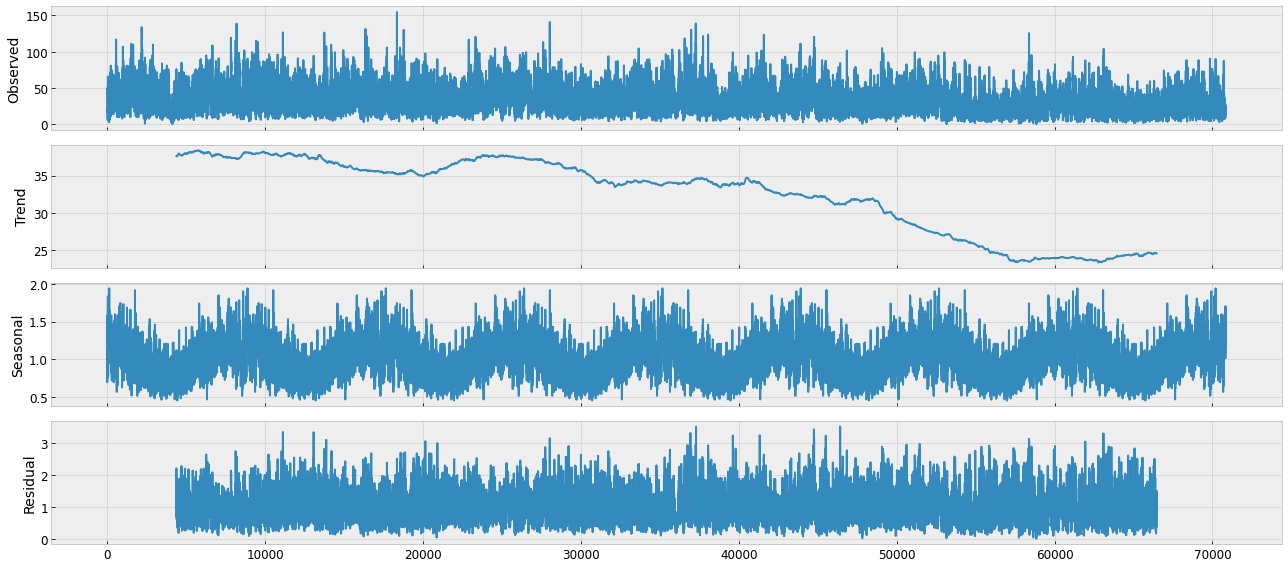

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.NO2
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

### CAQI


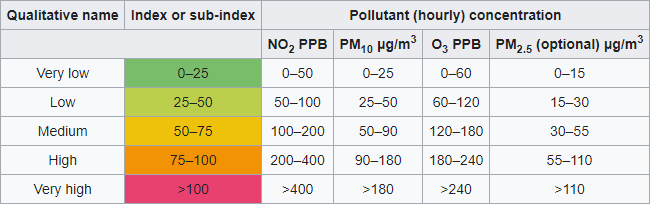


### CAQI Analysis

In [ ]:
palette = cycle(px.colors.sequential.Viridis)
df_graph = df[['timestamp_measured', 'CAQI']]
df2019 = df[df['timestamp_measured'].dt.year == 2019]
df2020 = df[df['timestamp_measured'].dt.year == 2020]
df2021 = df[df['timestamp_measured'].dt.year == 2021]

# chart
fig = make_subplots(rows=4, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "scatter"}], [{"colspan": 2}, None], [{"colspan": 2}, None], [{'type':'indicator'}, {'type':'bar'}]],
                    column_widths=[0.4, 0.6], vertical_spacing=0.1, horizontal_spacing=0.1,
                    subplot_titles=("Mean CAQI per Day of Week", "Hourly CAQI Trend", "Daily CAQI Trend", "2019 vs 2021", "Worst day: 1st of January 2019","CAQI Hourly Value Counts"))

# Upper Left chart
df_day = df_graph.groupby([df_graph["timestamp_measured"].dt.weekday]).mean().reset_index().sort_values(by='CAQI', ascending = False)
values = list(range(7))
fig.add_trace(go.Bar(x=df_day["timestamp_measured"], y=df_day['CAQI'], marker = dict(color=values, colorscale="Viridis"), 
                     name = 'Day of Week'),
                      row=1, col=1)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=1)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=1, col=1)

# Upper Right chart
df_hour = df_graph.groupby([df_graph["timestamp_measured"].dt.hour]).mean().reset_index('timestamp_measured')
fig.add_trace(go.Scatter(x=df_hour["timestamp_measured"], y=df_hour['CAQI'], mode='lines+markers',
               name='Hourly CAQI'), row = 1, col = 2)

# Rectangle to highlight range
fig.add_vrect(x0=5, x1=12,
              fillcolor=px.colors.sequential.Viridis[4],
              layer="below", 
              opacity=0.25, 
              line_width=0, 
              row = 1, col = 2
)

fig.add_annotation(dict(
        x=7,
        y=df_hour.loc[8,'CAQI']+0.004,
        text="There is a <b>peak at <br>7am</b> coinciding with<br>going to work.",
        ax="-20",
        ay="-60",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=1, col=2)

fig.add_annotation(dict(
        x=8.5,
        y=1.45,
        text="Morning hours are <br><b>the rush hours</b>.",
        showarrow = False
), row=1, col=2)

fig.add_annotation(dict(
        x=16,
        y=1.39,
        text="From 4pm <br> <b>CAQI<br> rises slightly again</b>.",
        ax="0",
        ay="-100",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=1, col=2)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=1, col=2)
fig.update_yaxes(showgrid = False, linecolor='gray', linewidth=2, row=1, col=2)

# Medium Chart
df_week = df_graph.groupby([df_graph["timestamp_measured"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week["timestamp_measured"], y = df_week['CAQI'], mode='lines',
                        marker = dict(color = px.colors.sequential.Viridis[5]),
                        name='Daily CAQI'), row = 2, col = 1)

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_week['CAQI'], model='additive', freq = 21)

fig.add_trace(go.Scatter(x = df_week["timestamp_measured"], y = decomp.trend, mode='lines',
                       marker = dict(color = medium),
                        name='CAQI Trend'), row = 2, col = 1)
    
fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, row=2, col=1)
fig.update_yaxes(gridcolor = 'gray', gridwidth = 0.15, linecolor='gray',linewidth=2, row=2, col=1)

df_week2019 = df2019.groupby([df2019["timestamp_measured"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week2019["timestamp_measured"], y = df_week2019['CAQI'], mode='lines',
                        marker = dict(color = px.colors.sequential.Viridis[2]),
                        name='2019'), row = 3, col = 1)
# df_week2020 = df2020.groupby([df2020["timestamp_measured"].dt.dayofyear]).mean().reset_index()
# fig.add_trace(go.Scatter(x = df_week2020["timestamp_measured"], y = df_week2020['CAQI'], mode='lines',
#                         marker = dict(color = px.colors.sequential.Viridis[5]),
#                         name='2020'), row = 3, col = 1)

df_week2021 = df2021.groupby([df2021["timestamp_measured"].dt.dayofyear]).mean().reset_index()
fig.add_trace(go.Scatter(x = df_week2021["timestamp_measured"], y = df_week2021['CAQI'], mode='lines',
                        marker = dict(color = px.colors.sequential.Viridis[8]),
                        name='2021'), row = 3, col = 1)

# Left Bottom Chart
fig.add_trace(go.Indicator(mode = "number", value = 537, title = 'The first hours of New Year always have bad air quality ', number = {'prefix': "PM10 "},), row = 4, col = 1)

# Right Bottom Chart
counts = df_graph['CAQI'].value_counts(ascending=False)
fig.add_trace(go.Bar(x=counts, y=['Very Low', 'Low', 'Medium', 'High', 'Very High'], marker = dict(color=colors), name = 'CAQI Values', orientation = 'h'),
                      row=4, col=2)

fig.update_xaxes(showgrid = False, linecolor='gray', linewidth = 2, zeroline = False, row=3, col=2)
fig.update_yaxes(showgrid = False, linecolor='gray',linewidth=2, zeroline = False, row=3, col=2)

fig.add_annotation(dict(
        x=33+0.15,
        y='Very High',
        text="Highest CAQI <br> are <b> more unusual</b>.",
        ax="110",
        ay="-20",
        showarrow = True,
        arrowhead = 7,
        arrowwidth = 0.7
), row=4, col=2)

# General Styling
fig.update_layout(height=1300, bargap=0.2,
                  margin=dict(b=50,r=30,l=100),
                  title = "<span style='font-size:36px; font-family:Times New Roman'>CAQI Analysis</span>",                  
                  plot_bgcolor='rgb(242,242,242)',
                  paper_bgcolor = 'rgb(242,242,242)',
                  font=dict(family="Times New Roman", size= 14),
                  hoverlabel=dict(font_color="floralwhite"),
                  showlegend=False)
fig.show()

df20 = df[df_graph['timestamp_measured'].dt.year >= 2019]
z = df20.groupby([df20["timestamp_measured"].dt.date])['CAQI'].mean()
display_years(z, (2019, 2020, 2021))



## 👓 References 
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials. 
 
Dataset 
* https://wdl-data.fra1.digitaloceanspaces.com/unstudio/stadhouderskade_air_quality_2014_to_2022.csv 
 
Paper 
* https://www.bmj.com/company/newsroom/long-term-exposure-to-air-pollution-linked-to-heightened-autoimmune-disease-risk/ 
* https://rmdopen.bmj.com/content/8/1/e002055 
 
Resource 
* https://www.iqair.com/us/netherlands/north-holland/amsterdam/amsterdam-stadhouderskade 
* https://www.euro.who.int/__data/assets/pdf_file/0020/123068/AQG2ndEd_5_14Toluene.PDF 
* https://www.kaggle.com/learn/feature-engineering 
* https://waqi.info/ 
* https://open.alberta.ca/dataset/22a3b2b2-19ba-49cd-8437-944050b53a90/resource/c7e769e7-43d9-4c6b-8401-a2e4f9cb626f/download/2004-assessmentreport-toluene-nov2004.pdf

## ⏭️ Appendix


#### Dickey-Fuller test and correlations

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=8760).mean()
        rolstd = y.rolling(window=8760).std()

        # Plot rolling statistics:
        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')

##### NO2

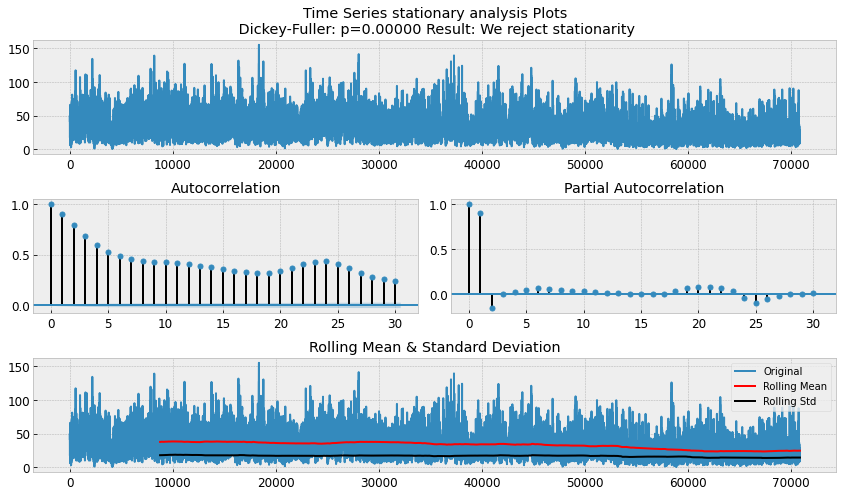

In [ ]:
tsplot(df.NO2, lags=30)

##### NO

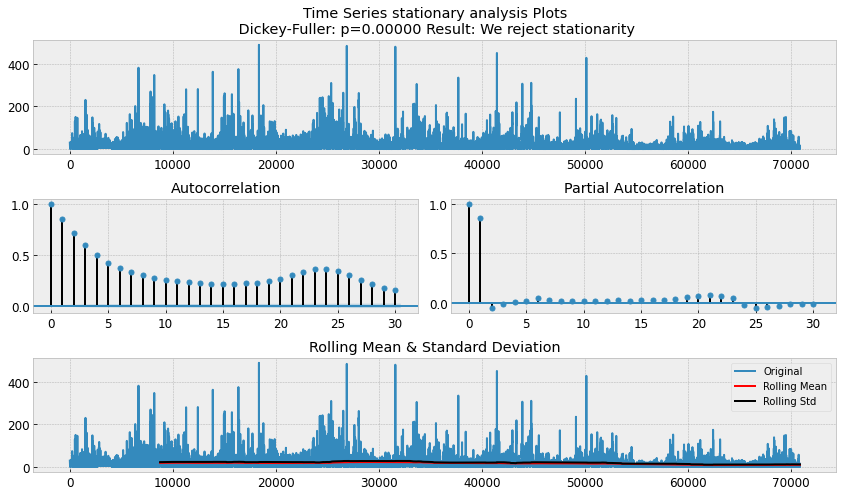

In [ ]:
tsplot(df.NO, lags=30)

##### FN

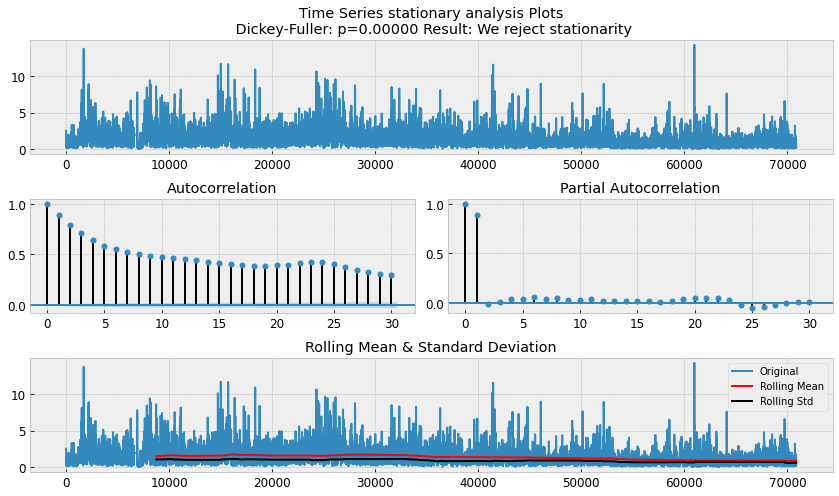

In [ ]:
tsplot(df.FN, lags=30)

##### C7H8

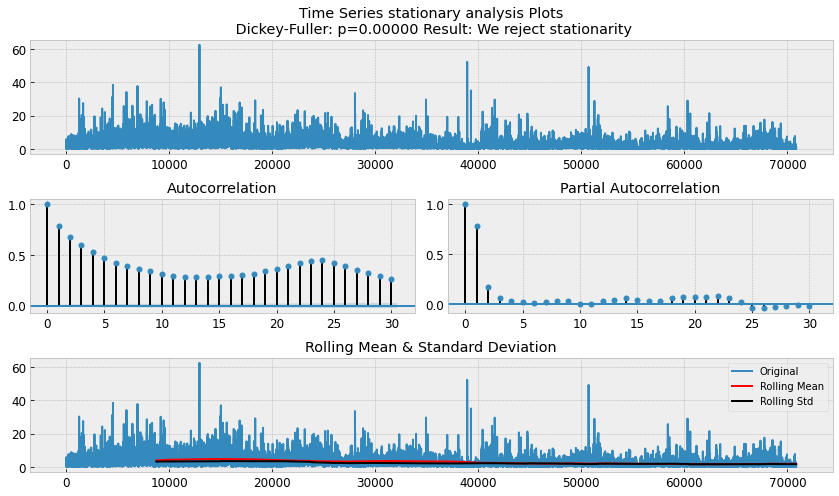

In [ ]:
tsplot(df.C7H8, lags=30)

##### C6H6

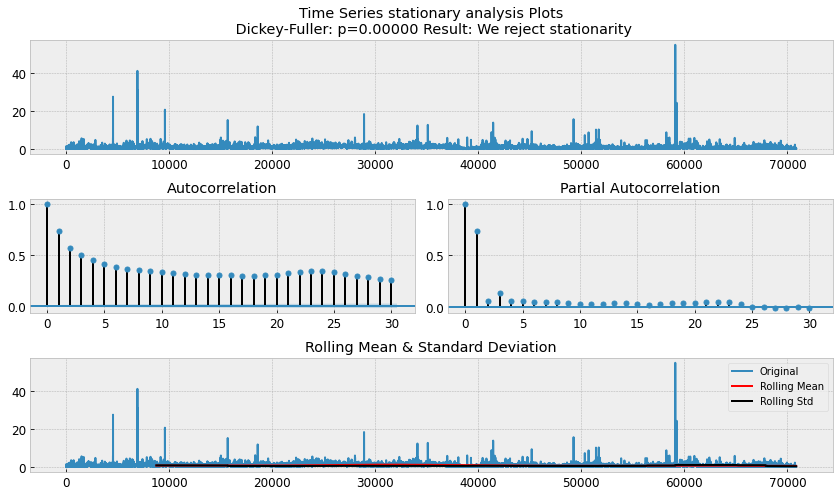

In [ ]:
tsplot(df.C6H6, lags=30)

##### PM2.5

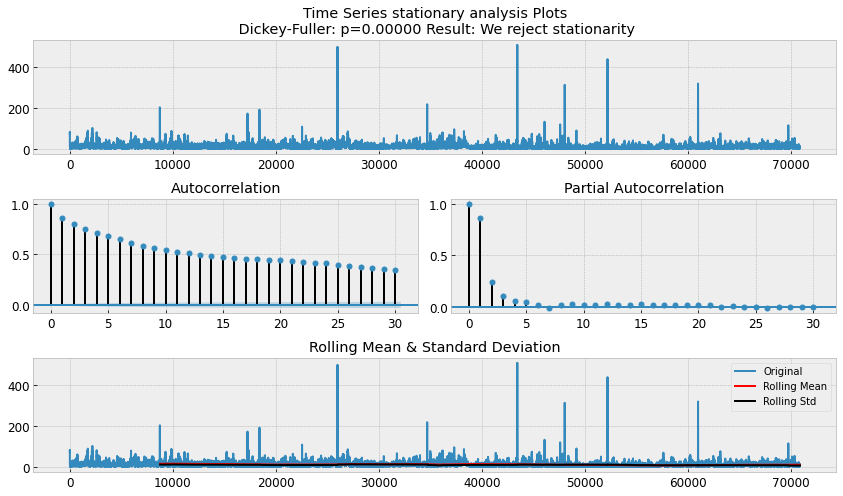

In [ ]:
tsplot(df.PM25, lags=30)

##### PM10

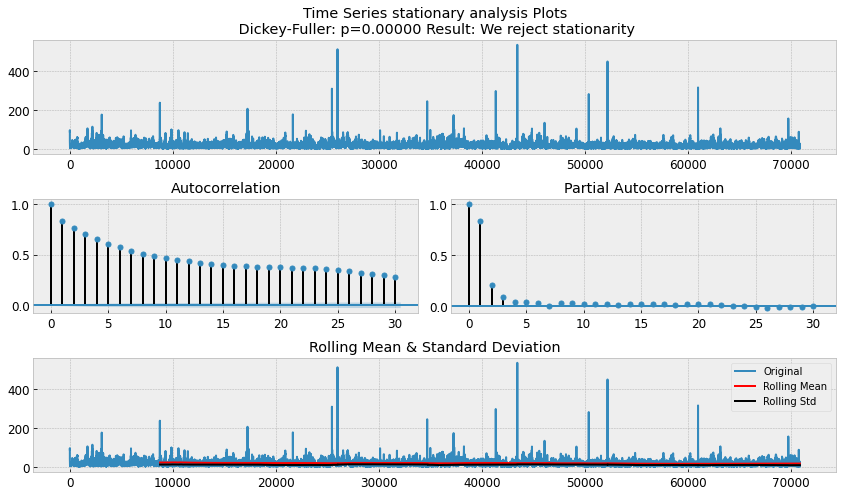

In [ ]:
tsplot(df.PM10, lags=30)

#### Looking at seasonal components
Plots for the remaining pollutants

## PCA

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(2, 1)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.2)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    # Set up figure
    fig.set(figwidth=width, dpi=100)
    return axs

In [ ]:
X = df.copy()
X_t = df.copy()

y = X.pop('PM25')
X = X.loc[:, features]
X_t = X_t.loc[:, features]

from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

X_pca.head(3)

PC1        PC2        PC3        PC4        PC5        PC6  \
0 -78.456568  27.830894  18.620100  11.567243  -2.228581   2.110587   
1 -62.563931  42.617926   8.226600 -10.412718  17.810346 -13.481167   
2 -47.664954  48.548953  -9.640234 -20.605061  11.033128   6.729953   

         PC7       PC8       PC9      PC10      PC11  
0   0.558017 -0.415846 -0.971011 -0.765919  0.220953  
1 -10.696555  4.969879 -2.083093  0.981662 -0.121546  
2  11.809898 -9.616620 -1.957614  1.008658 -0.491657

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings.head(6)

PC1       PC2       PC3       PC4       PC5       PC6  \
component_id                                                                 
NO2_lag_hour_1  0.346364  0.290575 -0.282207 -0.524232  0.469221 -0.363802   
NO2_lag_hour_2  0.368427  0.178299 -0.395443 -0.239301 -0.149779  0.463235   
FN              0.014201  0.019321  0.008768 -0.006630  0.006395 -0.007711   
NO              0.302751  0.727561  0.572957  0.209706 -0.063379  0.033477   
NO2_lag_hour_3  0.380026  0.021556 -0.356432  0.218821 -0.513850  0.132231   
NO2_lag_hour_4  0.380505 -0.142873 -0.174945  0.483420 -0.032924 -0.525285   

                     PC7       PC8       PC9      PC10      PC11  
component_id                                                      
NO2_lag_hour_1 -0.262064  0.125276 -0.063301 -0.013889  0.006817  
NO2_lag_hour_2  0.518123 -0.336651 -0.004892  0.000593 -0.000826  
FN             -0.004196  0.002338  0.058135  0.775586 -0.627908  
NO              0.015753 -0.006531 -0.030131 -0.018131  0.008649  
NO2_lag_hour_3 -0.395734  0.491988 -0.001752 -0.000160 -0.000770  
NO2_lag_hour_4 -0.023183 -0.541250  0.002439 -0.000335  0.000728

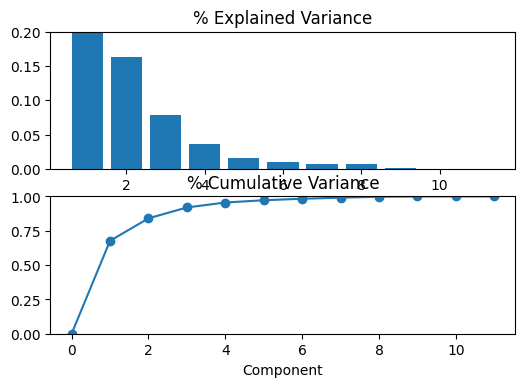

In [ ]:
plot_variance(pca, width=6);

In [ ]:
df_train = pd.concat([df, X_pca], axis=1)
df_test = pd.concat([df, X_t_pca], axis=1)

In [ ]:
from catboost import CatBoostRegressor
import eli5
from eli5.sklearn import PermutationImportance

tst_start = pd.to_datetime('2016-01-01 00:00', unit="ns", utc=True)
tst_finish = pd.to_datetime('2016-12-31 23:00', unit="ns", utc=True)

valid_test = df_train[(df_train['timestamp_measured'] >= tst_start) & (df_train['timestamp_measured'] <= tst_finish)].drop(['PM25'], axis=1)
valid_train = df_train[df_train['timestamp_measured'] < tst_start]

tmp = df_train[(df_train['timestamp_measured'] >= tst_start) & (df_train['timestamp_measured'] <= tst_finish)]
valid_target = tmp.pop('PM25')
valid_sample_submission = tmp.copy()
valid_sample_submission['PM25'] = 50
valid_sample_submission = valid_sample_submission['PM25'] 

X_train = valid_train.copy()
X_train = X_train.drop(['timestamp_measured'], axis=1)
Y_train = X_train['PM25']
X_train = X_train.drop(['PM25'], axis=1)

X_test = valid_test.drop(['timestamp_measured'], axis=1)

model = CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE').fit(X_train.values, Y_train.values)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, valid_target)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None)

##### NO

<Figure size 4000x1600 with 0 Axes>

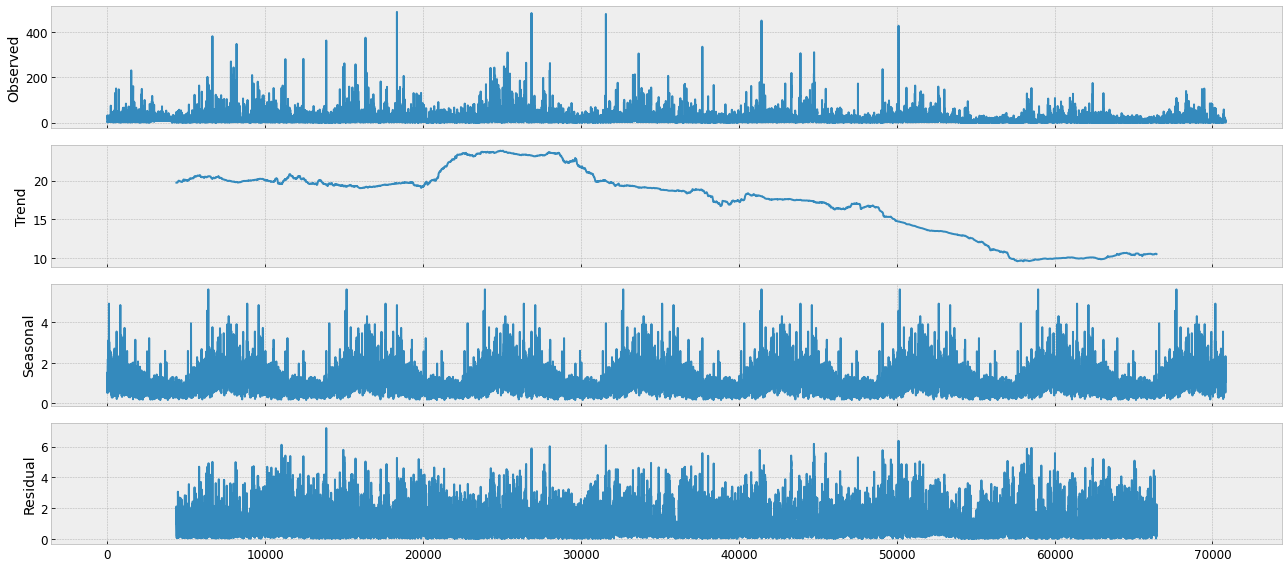

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.NO
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

##### FN

<Figure size 4000x1600 with 0 Axes>

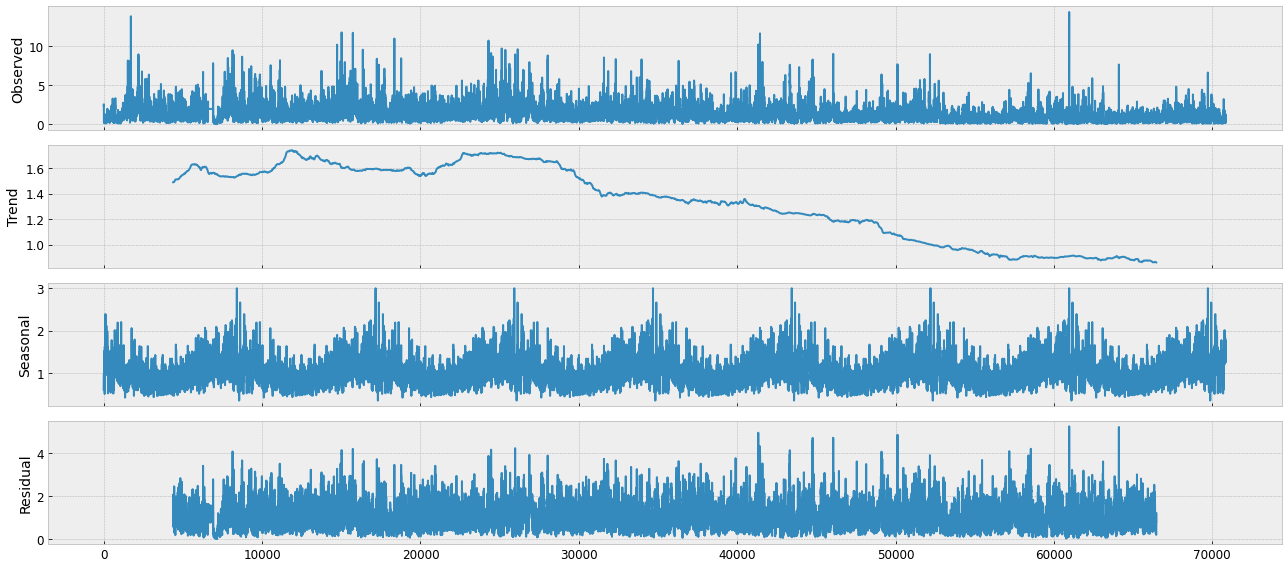

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.FN
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

##### C7H8

<Figure size 4000x1600 with 0 Axes>

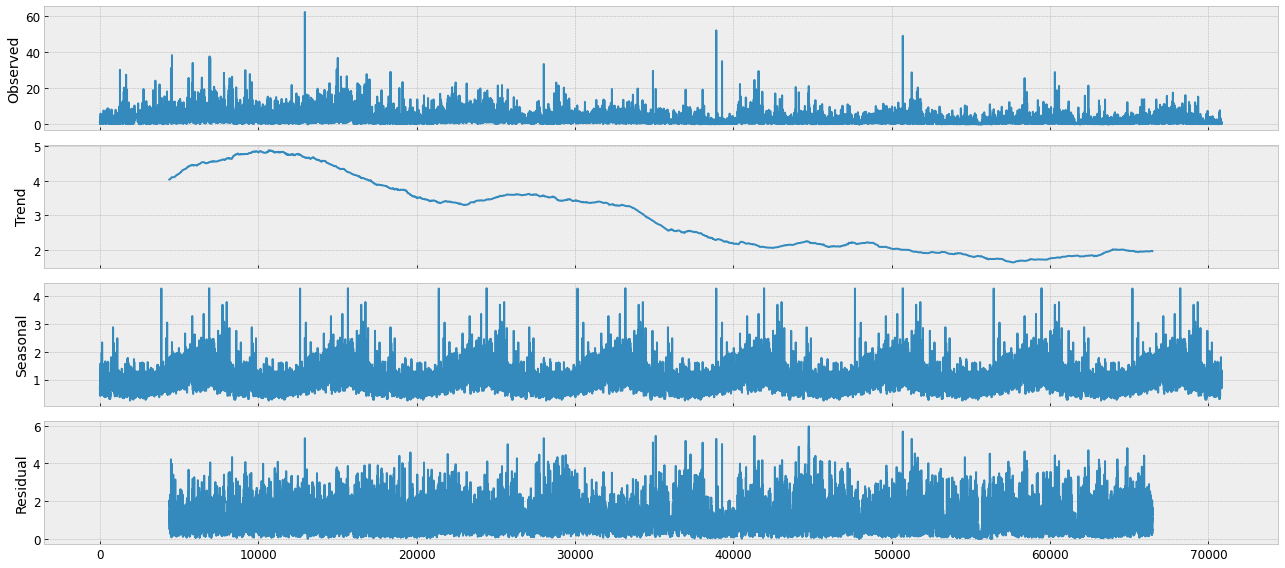

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.C7H8
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

##### C6H6

<Figure size 4000x1600 with 0 Axes>

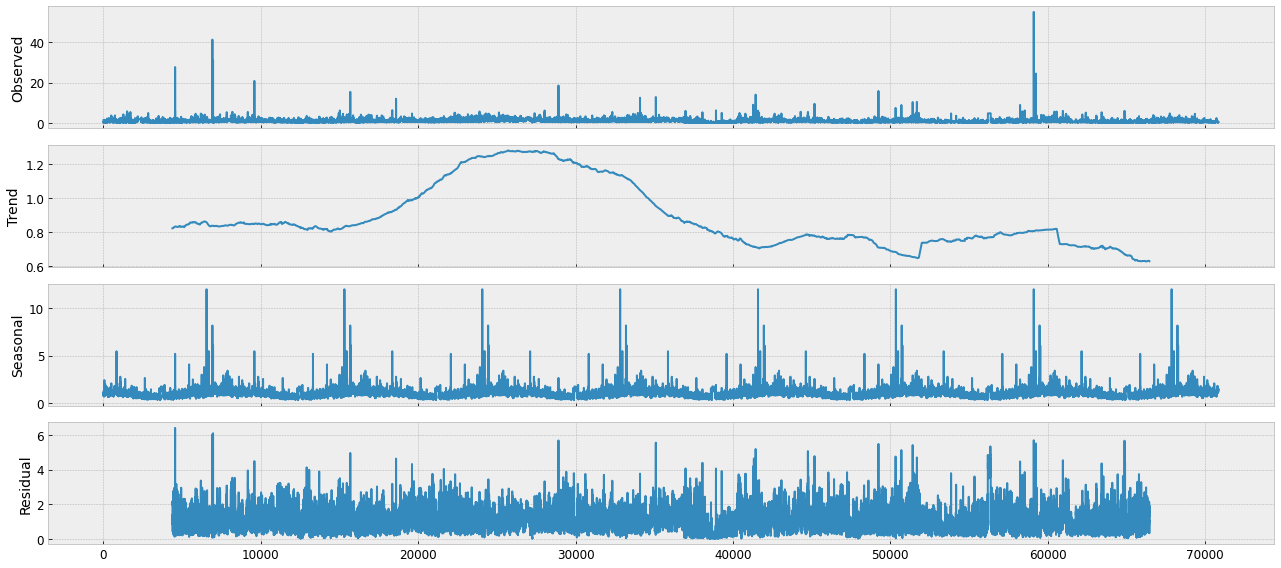

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.C6H6
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

##### PM2.5

<Figure size 4000x1600 with 0 Axes>

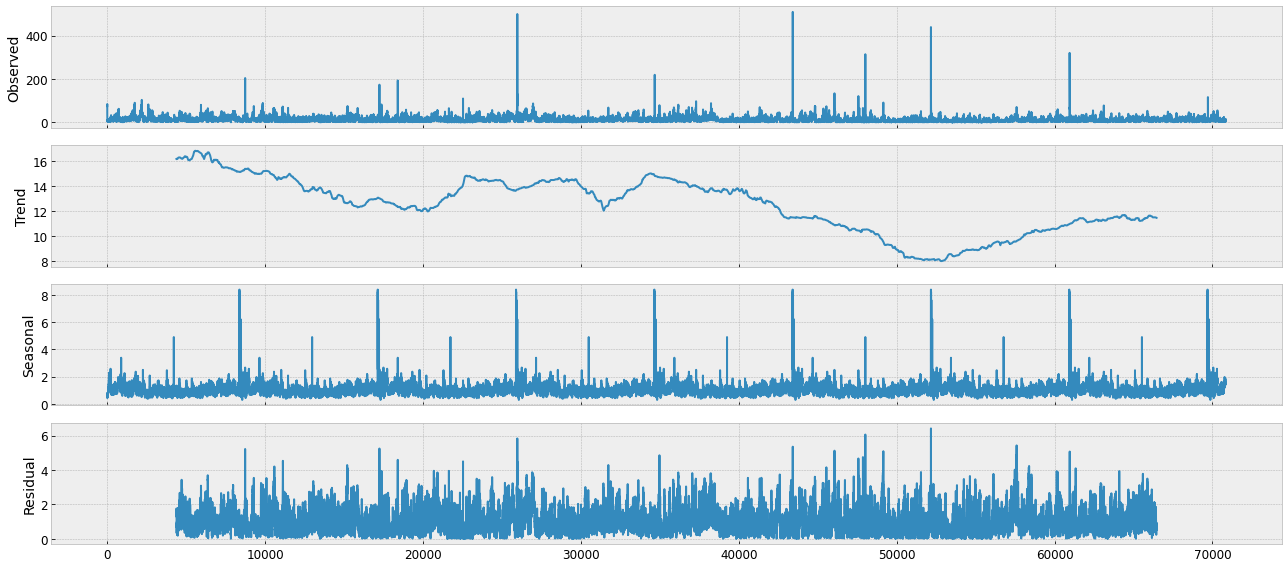

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.PM25
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

##### PM10

<Figure size 4000x1600 with 0 Axes>

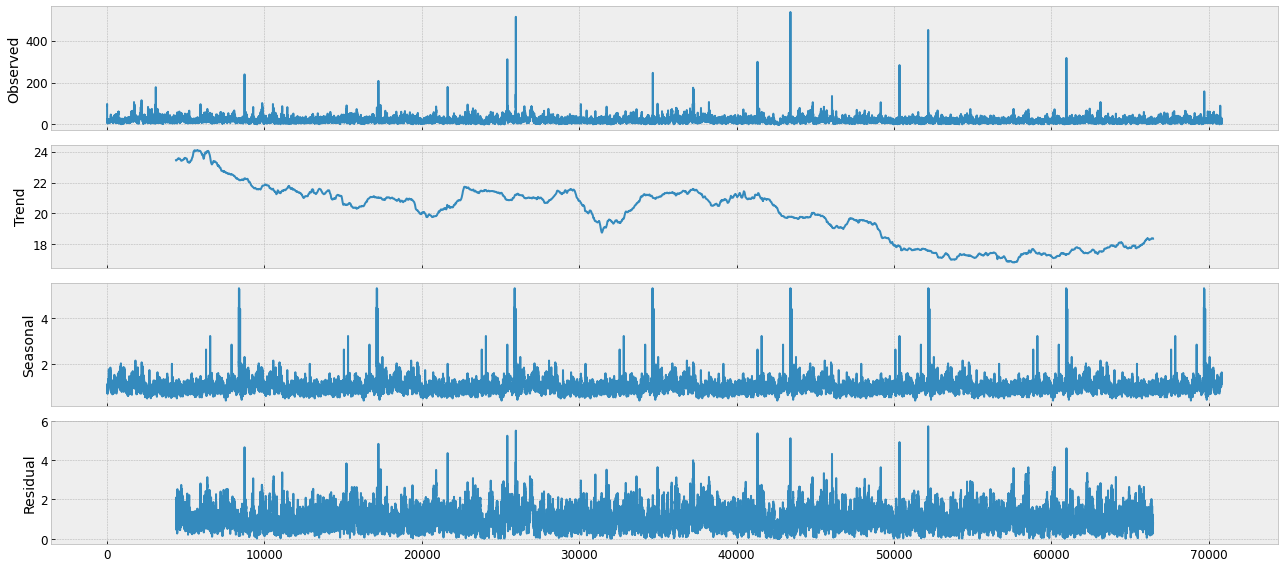

In [ ]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = df.PM10
result = seasonal_decompose(series, model='multiplicative', freq = 8760)
res = result.plot()

## Permutation Importance

In [ ]:
from catboost import CatBoostRegressor
import eli5
from eli5.sklearn import PermutationImportance

tst_start = pd.to_datetime('2016-01-01 00:00', unit="ns", utc=True)
tst_finish = pd.to_datetime('2016-12-31 23:00', unit="ns", utc=True)

res = []
for t in targets:
  valid_test = df[(df['timestamp_measured'] >= tst_start) & (df['timestamp_measured'] <= tst_finish)].drop([t], axis=1)
  valid_train = df[df['timestamp_measured'] < tst_start]

  tmp = df[(df['timestamp_measured'] >= tst_start) & (df['timestamp_measured'] <= tst_finish)]
  valid_target = tmp.pop(t)

  X_train = valid_train.copy()
  X_train = X_train.drop(['timestamp_measured'], axis=1)
  Y_train = X_train[t]
  X_train = X_train.drop([t], axis=1)

  X_test = valid_test.drop(['timestamp_measured'], axis=1)

  model = CatBoostRegressor(logging_level='Silent', random_state=42, eval_metric='MAE', loss_function='MAE').fit(X_train.values, Y_train.values)
  perm = PermutationImportance(model, random_state=1).fit(X_test, valid_target)
  display(eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=None))

We also tested some statistical features, but they were not as useful.

In [ ]:
# Statistical features
targets = ['NO2', 'PM10', 'PM25']
for t in targets:
  medians = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].median().astype(int)).reset_index()
  medians = medians.rename(columns={t:f'{t}_median'})
  df = df.merge(medians, on=['weekday', 'hour'], how='left')

  stds = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].std().astype(int)).reset_index()
  stds = stds.rename(columns={t:f'{t}_std'})
  df = df.merge(stds, on=['weekday', 'hour'], how='left')

  mins = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].min().astype(int)).reset_index()
  mins = mins.rename(columns={t:f'{t}_min'})
  df = df.merge(mins, on=['weekday', 'hour'], how='left')

  maxs = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].max().astype(int)).reset_index()
  maxs = maxs.rename(columns={t:f'{t}_max'})
  df = df.merge(maxs, on=['weekday', 'hour'], how='left')

  df_mornings = df[(df.hour >= 6) & (df.hour < 12)]
  morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day'])[t].median().astype(int)).reset_index()
  morning_avgs = morning_avgs.rename(columns={t:f'{t}_morning_avg'})
  df = df.merge(morning_avgs, on=['month', 'day'], how='left')

  quantile25 = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].quantile([.25]).astype(int)).reset_index()
  quantile25 = quantile25.rename(columns={t:f'{t}_quantile25'}).drop(['level_2'], axis=1)
  df = df.merge(quantile25, on=['weekday', 'hour'], how='left')

  quantile75 = pd.DataFrame(df.groupby(['weekday', 'hour'])[t].quantile([.75]).astype(int)).reset_index()
  quantile75 = quantile75.rename(columns={t:f'{t}_quantile75'}).drop(['level_2'], axis=1)
  df = df.merge(quantile75, on=['weekday', 'hour'], how='left')